In [17]:
import pandas as pd
import requests
import os
import numpy as np, pandas as pd
from datetime import datetime, timezone
from math import sqrt, exp, log
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from scipy.optimize import least_squares, curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

In [18]:
try:
    ALL = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/combined_options_data.parquet')
    CLEAN = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/cleaned_options_data.parquet')
    print("Successfully loaded data from Parquet.")
    display(ALL.head())
    display(CLEAN.head())
except FileNotFoundError:
    print("Error: combined_options_data.parquet not found. Please make sure the file is in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the parquet: {e}")

Successfully loaded data from Parquet.


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency,asof
0,JPM,312.05,JPM251205C00160000,2025-12-05,1,160.0,call,5,21,149.50,2025-12-03 11:15:02-05:00,150.1,153.75,1.059998,0.007141,5.333988,True,USD,2025-12-04
1,JPM,312.05,JPM251205P00160000,2025-12-05,1,160.0,put,500,500,0.01,2025-11-28 11:33:45-05:00,0.0,0.22,0.000000,0.000000,3.578126,False,USD,2025-12-04
2,JPM,312.05,JPM251205C00165000,2025-12-05,1,165.0,call,60,21,144.56,2025-12-03 11:15:02-05:00,145.1,148.75,1.069992,0.007457,5.119144,True,USD,2025-12-04
3,JPM,312.05,JPM251205P00165000,2025-12-05,1,165.0,put,501,1,0.16,2025-12-01 09:45:06-05:00,0.0,0.22,0.000000,0.000000,3.429689,False,USD,2025-12-04
4,JPM,312.05,JPM251205C00170000,2025-12-05,1,170.0,call,0,2,139.20,2025-12-03 12:09:56-05:00,140.3,143.30,-0.949997,-0.006778,4.613285,True,USD,2025-12-04


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,...,in_the_money,currency,asof,T,lastPrice,mid,spread,S,k,iv_clean
0,JPM,312.05,JPM251205C00160000,2025-12-05,1,160.0,call,5,21,149.50,...,True,USD,2025-12-04,0.00274,NaN,151.925,3.65,312.130005,-0.668246,5.240727
1,JPM,312.05,JPM251205P00160000,2025-12-05,1,160.0,put,500,500,0.01,...,False,USD,2025-12-04,0.00274,NaN,0.110,0.22,312.130005,-0.668246,5.055193
2,JPM,312.05,JPM251205C00165000,2025-12-05,1,165.0,call,60,21,144.56,...,True,USD,2025-12-04,0.00274,NaN,146.925,3.65,312.130005,-0.637474,5.015186
3,JPM,312.05,JPM251205P00165000,2025-12-05,1,165.0,put,501,1,0.16,...,False,USD,2025-12-04,0.00274,NaN,0.110,0.22,312.130005,-0.637474,4.839102
4,JPM,312.05,JPM251205C00170000,2025-12-05,1,170.0,call,0,2,139.20,...,True,USD,2025-12-04,0.00274,NaN,141.800,3.00,312.130005,-0.607621,3.964603


In [19]:
try:
    KK = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/KK_grid.npy')
    TT = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/TT_grid.npy')
    IV = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/IV_grid.npy')
    print("Successfully loaded KK, TT, and IV from .npy files.")
except FileNotFoundError:
    print("Error: One or more .npy files not found. Please make sure the files are in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the .npy files: {e}")

Successfully loaded KK, TT, and IV from .npy files.



✅ Surface analysis complete.

--- Visualizing Surface Derivatives ---


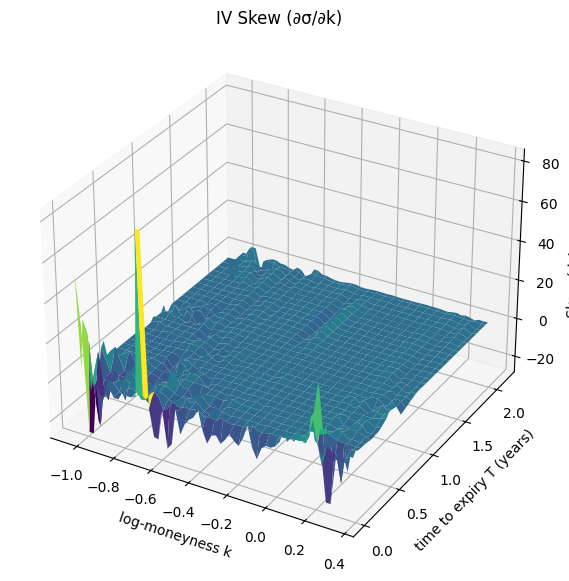

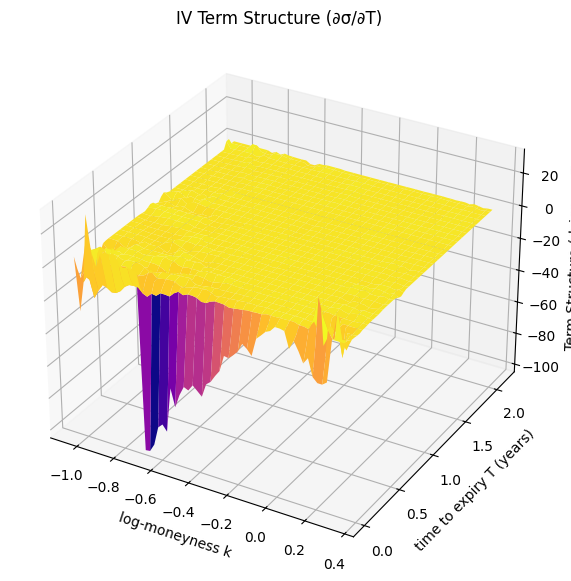

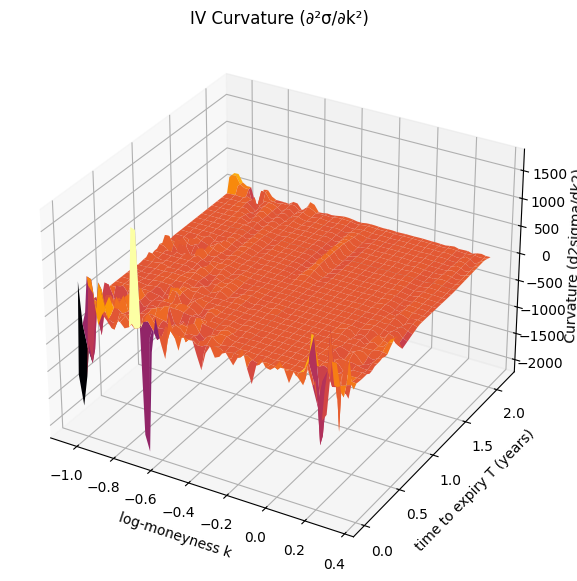

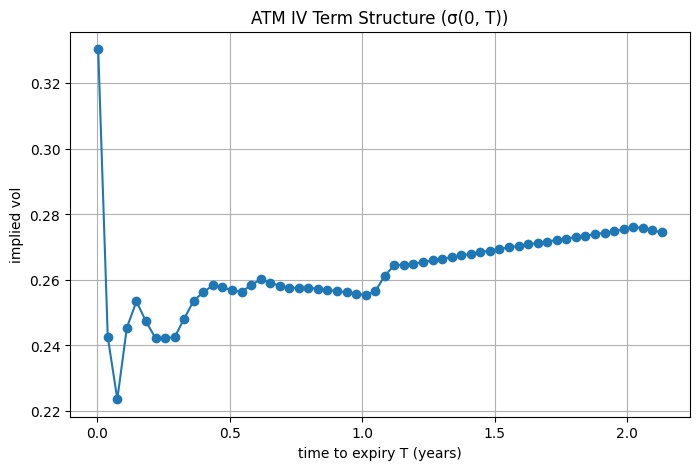

In [20]:
# --- Analyze the IV surface: Skew, Term Structure, Curvature ---

if KK is None or TT is None or IV is None:
    print("Surface grids (KK, TT, IV) not available. Run the previous cell first.")
else:
    # Calculate derivatives (finite differences)
    # Skew: d(sigma)/d(k)
    dsigma_dk = np.gradient(IV, axis=1) / np.gradient(KK, axis=1)

    # Term structure: d(sigma)/d(T)
    dsigma_dT = np.gradient(IV, axis=0) / np.gradient(TT, axis=0)

    # Curvature: d^2(sigma)/d(k)^2
    d2sigma_dk2 = np.gradient(dsigma_dk, axis=1) / np.gradient(KK, axis=1)

    # ATM Term Structure: sigma(k=0, T)
    # Find the index closest to k=0 for each T
    atm_iv = []
    atm_T = []
    for i in range(IV.shape[0]):
        k_row = KK[i, :]
        closest_k_idx = np.argmin(np.abs(k_row))
        atm_iv.append(IV[i, closest_k_idx])
        atm_T.append(TT[i, closest_k_idx])

    print("\n✅ Surface analysis complete.")

    # --- Visualization ---

    print("\n--- Visualizing Surface Derivatives ---")

    # Plot Skew (dsigma/dk)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, dsigma_dk, cmap='viridis', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Skew (dsigma/dk)")
    ax.set_title("IV Skew (∂σ/∂k)")
    plt.show()

    # Plot Term Structure (dsigma/dT)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, dsigma_dT, cmap='plasma', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Term Structure (dsigma/dT)")
    ax.set_title("IV Term Structure (∂σ/∂T)")
    plt.show()

    # Plot Curvature (d2sigma/dk2)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, d2sigma_dk2, cmap='inferno', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Curvature (d2sigma/dk2)")
    ax.set_title("IV Curvature (∂²σ/∂k²)")
    plt.show()

    # Plot ATM Term Structure (sigma(k=0, T))
    plt.figure(figsize=(8, 5))
    plt.plot(atm_T, atm_iv, marker='o')
    plt.xlabel("time to expiry T (years)")
    plt.ylabel("implied vol")
    plt.title("ATM IV Term Structure (σ(0, T))")
    plt.grid(True)
    plt.show()


Fitting models for expiry 2025-12-05 (T=0.003y)
SVI fitting failed for expiry T=0.003y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2025-12-12 (T=0.022y)
SVI fitting failed for expiry T=0.022y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2025-12-19 (T=0.041y)
SVI Params (a,b,rho,m,sigma): [ -7.3339 136.7401  -1.      -1.7684   0.4365]


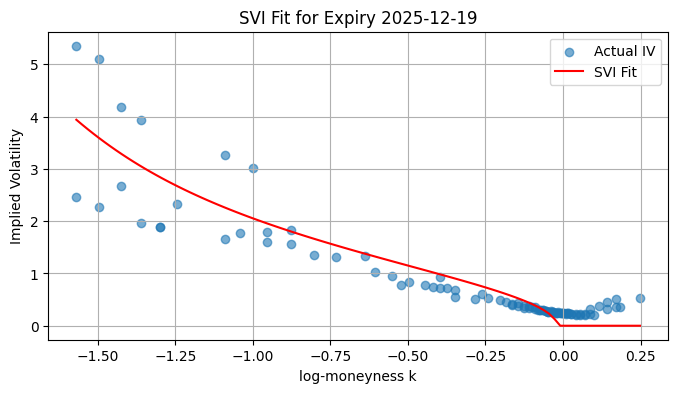


Fitting models for expiry 2025-12-26 (T=0.060y)
SVI fitting failed for expiry T=0.060y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2026-01-02 (T=0.079y)
SVI fitting failed for expiry T=0.079y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2026-01-09 (T=0.099y)
SVI Params (a,b,rho,m,sigma): [ 0.0049  0.7325 -0.9423 -0.0683  0.1831]


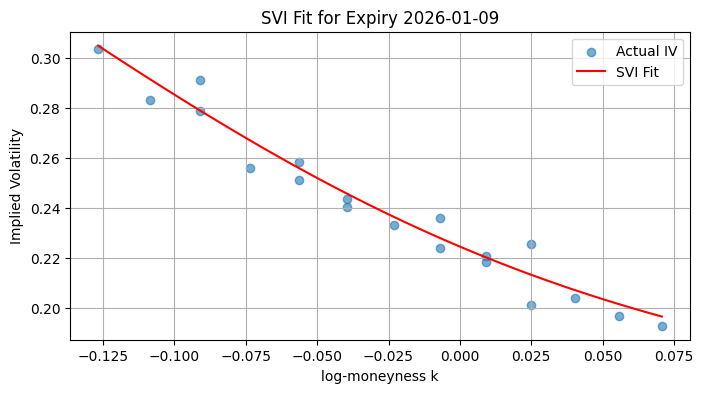


Fitting models for expiry 2026-01-16 (T=0.118y)
SVI Params (a,b,rho,m,sigma): [-1.462   6.2973 -0.2041 -0.3051  0.2571]


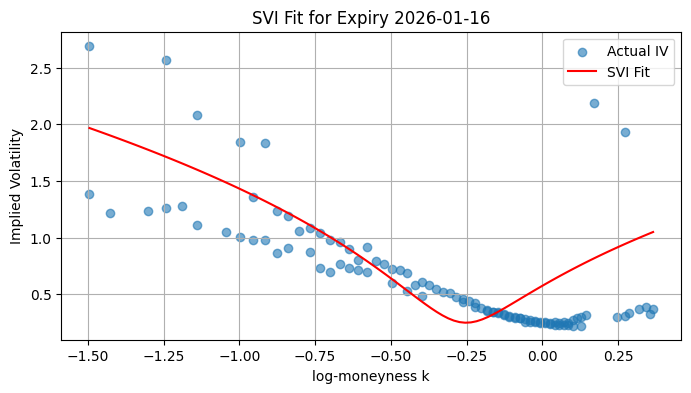


Fitting models for expiry 2026-02-20 (T=0.214y)
SVI Params (a,b,rho,m,sigma): [ 0.1019  1.6302 -0.9778 -0.2656  0.0909]


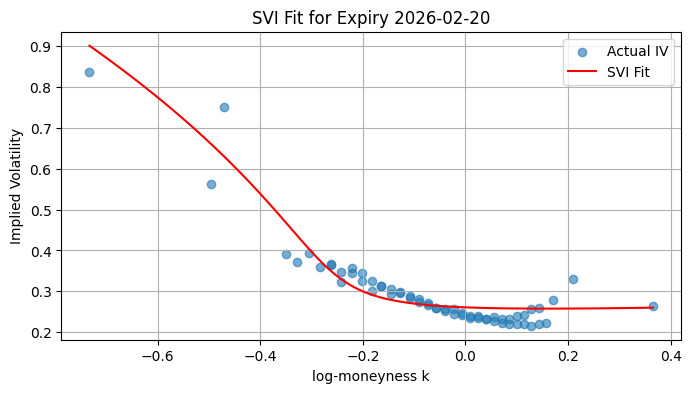


Fitting models for expiry 2026-03-20 (T=0.290y)
SVI Params (a,b,rho,m,sigma): [-0.2195  1.9247 -0.7197 -0.369   0.2744]


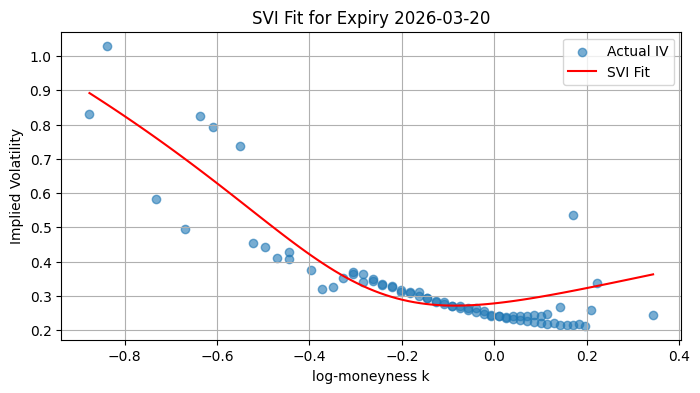


Fitting models for expiry 2026-04-17 (T=0.367y)
SVI Params (a,b,rho,m,sigma): [ 0.0981  0.3925 -1.     -0.0913  0.1336]


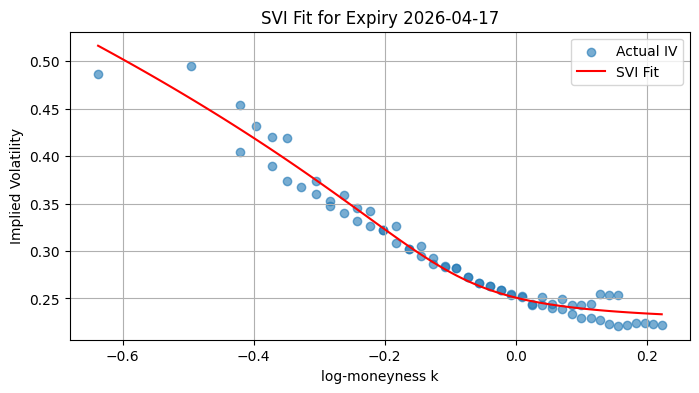


Fitting models for expiry 2026-05-15 (T=0.444y)
SVI Params (a,b,rho,m,sigma): [-0.6403  1.7934 -0.1231 -0.0516  0.42  ]


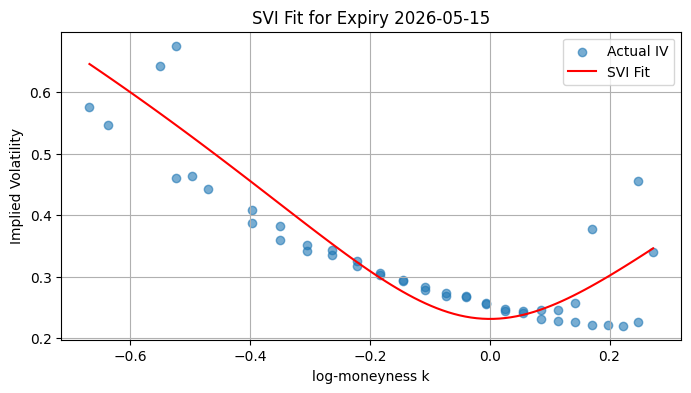


Fitting models for expiry 2026-06-18 (T=0.537y)
SVI fitting failed for expiry T=0.537y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2026-07-17 (T=0.616y)
SVI Params (a,b,rho,m,sigma): [-0.3069 10.2711 -0.9901 -1.0909  0.2677]


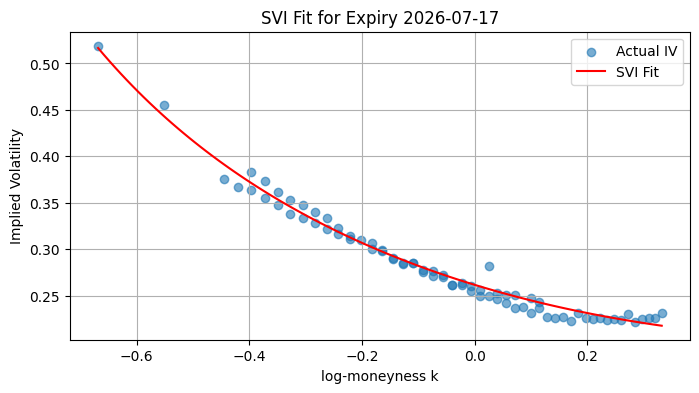


Fitting models for expiry 2026-08-21 (T=0.712y)
SVI Params (a,b,rho,m,sigma): [ 0.1506  0.9838 -1.     -0.4985  0.1301]


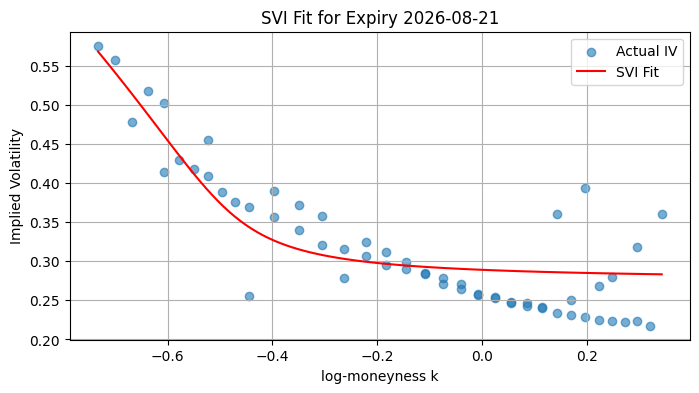


Fitting models for expiry 2026-09-18 (T=0.789y)
SVI Params (a,b,rho,m,sigma): [ 0.0984  0.7689 -0.9799 -0.3932  0.1944]


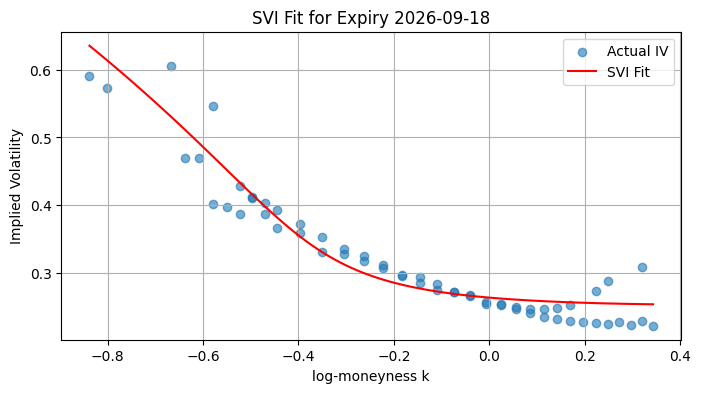


Fitting models for expiry 2026-12-18 (T=1.038y)
SVI Params (a,b,rho,m,sigma): [ 0.1261  1.1389 -0.9831 -0.6025  0.1696]


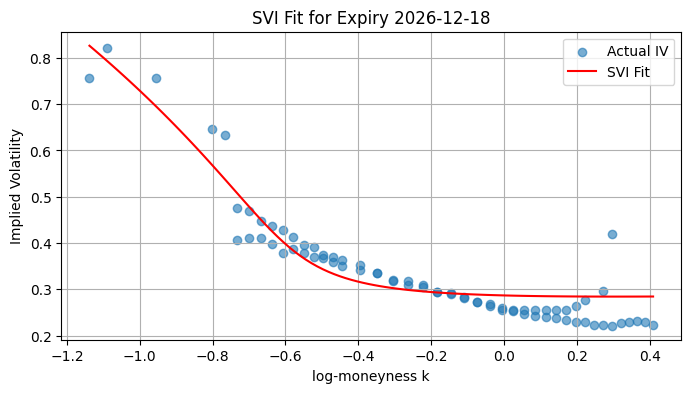


Fitting models for expiry 2027-01-15 (T=1.115y)
SVI Params (a,b,rho,m,sigma): [-1.0899  4.2335 -0.8916 -1.2235  0.639 ]


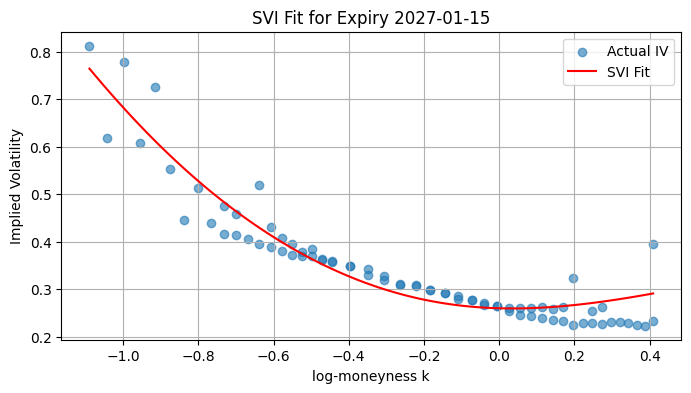


Fitting models for expiry 2027-06-17 (T=1.534y)
SVI fitting failed for expiry T=1.534y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2027-12-17 (T=2.036y)
SVI fitting failed for expiry T=2.036y: The maximum number of function evaluations is exceeded.

Fitting models for expiry 2028-01-21 (T=2.132y)
SVI fitting failed for expiry T=2.132y: The maximum number of function evaluations is exceeded.

✅ Model fitting process initiated. Check outputs for results per expiry.
SVI fits stored in 'svi_fits' dictionary.


In [21]:
# Implement SVI model fitting
def svi_variance(k, T, a, b, rho, m, sigma):
    """SVI total variance function."""
    return 0.5 * (a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))) * T

def svi_vol(k, T, a, b, rho, m, sigma):
    """SVI implied volatility function."""
    total_variance = svi_variance(k, T, a, b, rho, m, sigma)
    # Handle potential non-positive total variance (can happen with poor parameters)
    total_variance = np.maximum(1e-9, total_variance)
    return np.sqrt(total_variance / T)

def svi_objective(params, k, T, target_vol):
    """Objective function for SVI fitting (minimize squared errors)."""
    a, b, rho, m, sigma = params
    # Constraints check
    if sigma <= 0 or b < 0 or abs(rho) > 1:
         return np.inf * np.ones_like(k) # Penalize invalid parameters

    model_vol = svi_vol(k, T, a, b, rho, m, sigma)
    return (model_vol - target_vol)**2

def fit_svi(df_expiry):
    """Fits SVI model to data for a single expiry."""
    if df_expiry.empty: return None, None
    k = df_expiry["k"].values
    T = df_expiry["T"].iloc[0]
    target_vol = df_expiry["iv_clean"].values

    # Initial guess for SVI parameters
    a0 = np.min(target_vol)**2 * T * 2 # related to ATM variance
    b0 = 0.1 # slope
    rho0 = -0.5 # typical skew
    m0 = 0.0 # ATM
    sigma0 = 0.1 # width

    initial_guess = [a0, b0, rho0, m0, sigma0]

    # Bounds for parameters
    bounds = ([-np.inf, 0, -1, -np.inf, 1e-3], [np.inf, np.inf, 1, np.inf, np.inf])

    try:
        # Use least_squares with bounds
        result = least_squares(svi_objective, initial_guess, bounds=bounds, args=(k, T, target_vol), method='trf')
        if result.success:
            params = result.x
            # Calculate fitted vols
            fitted_vols = svi_vol(k, T, *params)
            return params, fitted_vols
        else:
            print(f"SVI fitting failed for expiry T={T:.3f}y: {result.message}")
            return None, None
    except Exception as e:
        print(f"Error during SVI fitting for expiry T={T:.3f}y: {e}")
        return None, None

# Fit models to each expiry and store results

if 'CLEAN' not in globals() or CLEAN.empty:
    print("CLEAN DataFrame not found or is empty. Please run the data cleaning cell first.")
else:
    # Convert 'expiry' column to datetime objects
    CLEAN['expiry'] = pd.to_datetime(CLEAN['expiry'])
    svi_fits = {}

    for expiry, df_expiry in CLEAN.groupby("expiry"):
        T = df_expiry["T"].iloc[0]
        # Access the date using the .date() method on the datetime object
        print(f"\nFitting models for expiry {expiry.date()} (T={T:.3f}y)")

        # Fit SVI
        svi_params, svi_fitted_vols = fit_svi(df_expiry)
        if svi_params is not None:
            svi_fits[expiry] = {
                "params": svi_params,
                "fitted_vols": svi_fitted_vols,
                "k": df_expiry["k"].values,
                "actual_vols": df_expiry["iv_clean"].values
            }
            print("SVI Params (a,b,rho,m,sigma):", np.round(svi_params, 4))
            # Simple visualization of SVI fit vs data
            plt.figure(figsize=(8, 4))
            plt.scatter(df_expiry["k"], df_expiry["iv_clean"], label="Actual IV", alpha=0.6)
            # Generate smooth curve for SVI
            k_smooth = np.linspace(df_expiry["k"].min(), df_expiry["k"].max(), 100)
            svi_smooth_vols = svi_vol(k_smooth, T, *svi_params)
            plt.plot(k_smooth, svi_smooth_vols, color='red', label='SVI Fit')
            plt.xlabel("log-moneyness k")
            plt.ylabel("Implied Volatility")
            plt.title(f"SVI Fit for Expiry {expiry.date()}")
            plt.legend()
            plt.grid(True)
            plt.show()

    print("\n✅ Model fitting process initiated. Check outputs for results per expiry.")
    print("SVI fits stored in 'svi_fits' dictionary.")

In [22]:
expiries = sorted(df_expiry['expiry'])

In [23]:
def svi_w(k, a,b,rho,m,sigma):
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sigma**2))

def svi_wprime(k, b,rho,m,sigma):
    return b*(rho + (k-m)/np.sqrt((k-m)**2 + sigma**2))

def svi_wpp(k, b,m,sigma):
    return b*(sigma**2)/(((k-m)**2 + sigma**2)**1.5)

def atm_metrics_from_row(params, T):
    """params = [a,b,rho,m,sig], returns (ATM_IV, ATM_skew, ATM_curv) at k=0"""
    a,b,rho,m,sigma = params
    k0 = 0.0
    w0  = svi_w(k0, a,b,rho,m,sigma)
    wp  = svi_wprime(k0, b,rho,m,sigma)
    wpp = svi_wpp(k0, b,m,sigma)
    iv_atm   = np.sqrt(max(w0, 0.0) / max(T, 1e-12))
    skew_atm = 0.5 * wp / np.sqrt(max(T*w0, 1e-12))
    curv_atm = 0.5/np.sqrt(max(T,1e-12)) * (
        - (wp**2) / (4*(w0**1.5 + 1e-18)) + (wpp / (2*np.sqrt(w0 + 1e-18)))
    )
    return float(iv_atm), float(skew_atm), float(curv_atm)

In [24]:
rows = []
asof_value = CLEAN['asof'].iloc[0]
# sort the expiries
expiry_order = sorted(svi_fits.keys())

for i, exp in enumerate(expiry_order):
    # Retrieve the stored SVI data for this specific expiry
    exp_data = svi_fits[exp]
    params = exp_data["params"] # This is the array/tuple [a,b,rho,m,sigma]

    # Get T for the current expiry (exp) from the original CLEAN DataFrame
    try:
        T_series = CLEAN.loc[CLEAN['expiry'] == exp, 'T']
        if not T_series.empty:
            T = T_series.iloc[0]
        else:
            print(f"Warning: Expiry {exp} from svi_fits not found in CLEAN DataFrame to get 'T'. Skipping.")
            continue
    except NameError:
        print("Error: CLEAN DataFrame not found in current scope. Cannot retrieve 'T'.")
        print("Please ensure the 'CLEAN' DataFrame is loaded and accessible.")
        break
    iv_atm, skew_atm, curv_atm = atm_metrics_from_row(params, T)
    a, b, rho, m, sigma = params

    rows.append({
        'asof':asof_value,
        'expiry': exp,
        'T': T,
        'ATM_IV': iv_atm,
        'ATM_skew': skew_atm,
        'ATM_curvature': curv_atm,
        'a': a,
        'b': b,
        'rho': rho,
        'm': m,
        'sigma': sigma
    })

metrics = pd.DataFrame(rows).sort_values(['asof', 'T']).reset_index(drop=True)
METRICS_DIR = '/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics'
os.makedirs(METRICS_DIR, exist_ok=True)

asof_date = pd.to_datetime(asof_value).date()
metrics_path = os.path.join(METRICS_DIR, f'svi_metrics_{asof_date}.parquet')

metrics.to_parquet(metrics_path, index=False)
print(f"Saved SVI metrics to {metrics_path}")
print("SVI Metrics DataFrame head:")
print(metrics.head())


Saved SVI metrics to /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/svi_metrics_2025-12-04.parquet
SVI Metrics DataFrame head:
        asof     expiry         T    ATM_IV      ATM_skew  ATM_curvature  \
0 2025-12-04 2025-12-19  0.041096  0.000000 -1.991846e+06            NaN   
1 2025-12-04 2026-01-09  0.098630  1.011401 -2.176621e+00       5.906677   
2 2025-12-04 2026-01-16  0.117808  2.363915  6.336934e+00      -2.608464   
3 2025-12-04 2026-02-20  0.213699  0.798412 -1.513828e-01       0.878495   
4 2025-12-04 2026-03-20  0.290411  0.729041  3.759850e-01       1.662548   

          a           b       rho         m     sigma  
0 -7.333871  136.740135 -1.000000 -1.768365  0.436453  
1  0.004899    0.732518 -0.942272 -0.068274  0.183059  
2 -1.462048    6.297266 -0.204125 -0.305068  0.257143  
3  0.101932    1.630200 -0.977774 -0.265564  0.090923  
4 -0.219539    1.924668 -0.719750 -0.369039  0.274406  


/tmp/ipython-input-2395414202.py:20: RuntimeWarning: invalid value encountered in scalar power
  - (wp**2) / (4*(w0**1.5 + 1e-18)) + (wpp / (2*np.sqrt(w0 + 1e-18)))
/tmp/ipython-input-2395414202.py:20: RuntimeWarning: invalid value encountered in sqrt
  - (wp**2) / (4*(w0**1.5 + 1e-18)) + (wpp / (2*np.sqrt(w0 + 1e-18)))
